# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
Review criteriaменьше 
Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
+ Стабилизация дисперсии (при необходимости)
+ Выбор порядка дифференцирования
+ Выбор начальных приближений для p,q,P,Q
+ Обучение и сравнение моделей-кандидатов, выбор победителя
+ Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
+ Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.


In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('WAG_C_M.csv',sep=';',index_col=['month'], parse_dates=['month'],dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### 1. Визуальный анализ ряда

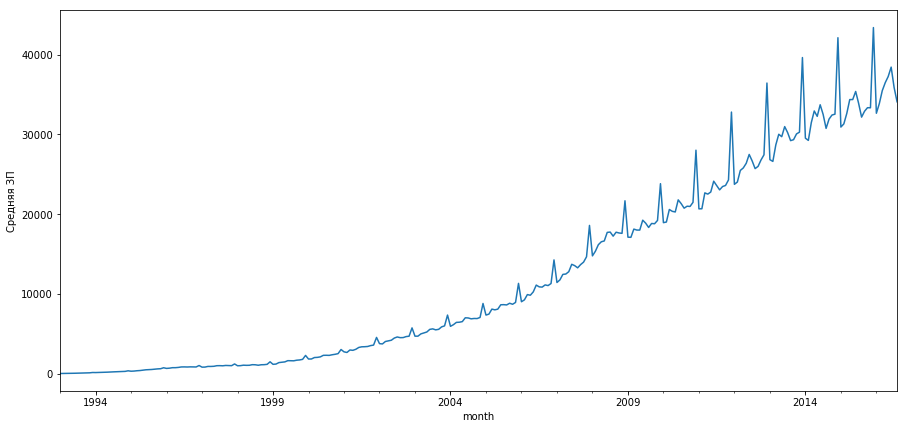

In [4]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Средняя ЗП')
pylab.show()

В ряде виден **тренд** и **сезонность**, значит он не стационарен

Проверка стационарности и STL-декомпозици¤ р¤да:

Критерий Дики-Фуллера: p=0.991850


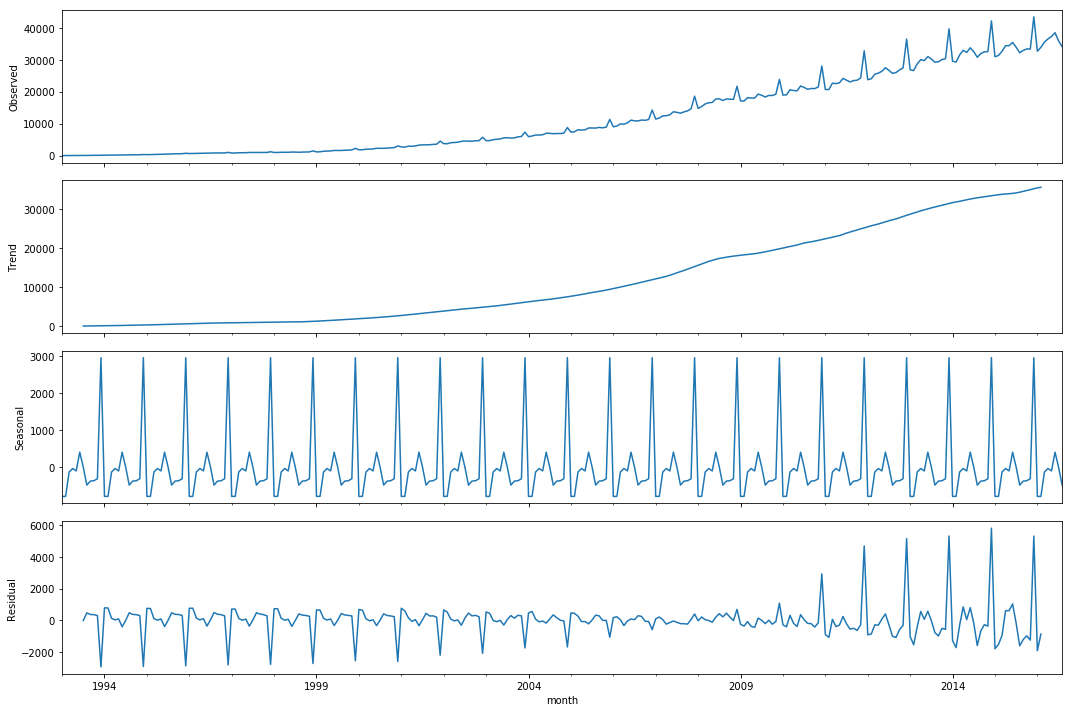

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса- Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


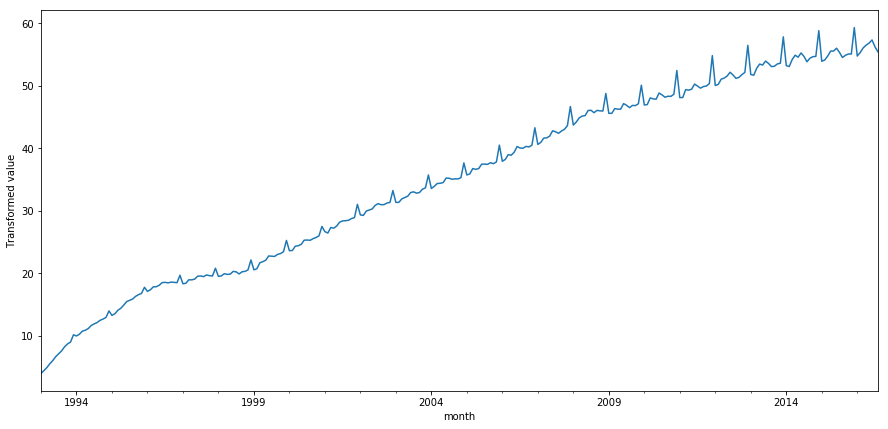

In [6]:
data['box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.box.plot()
plt.ylabel(u'Transformed value')
print("Оптимальный параметр преобразования Бокса- Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box)[1])

### 3. Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


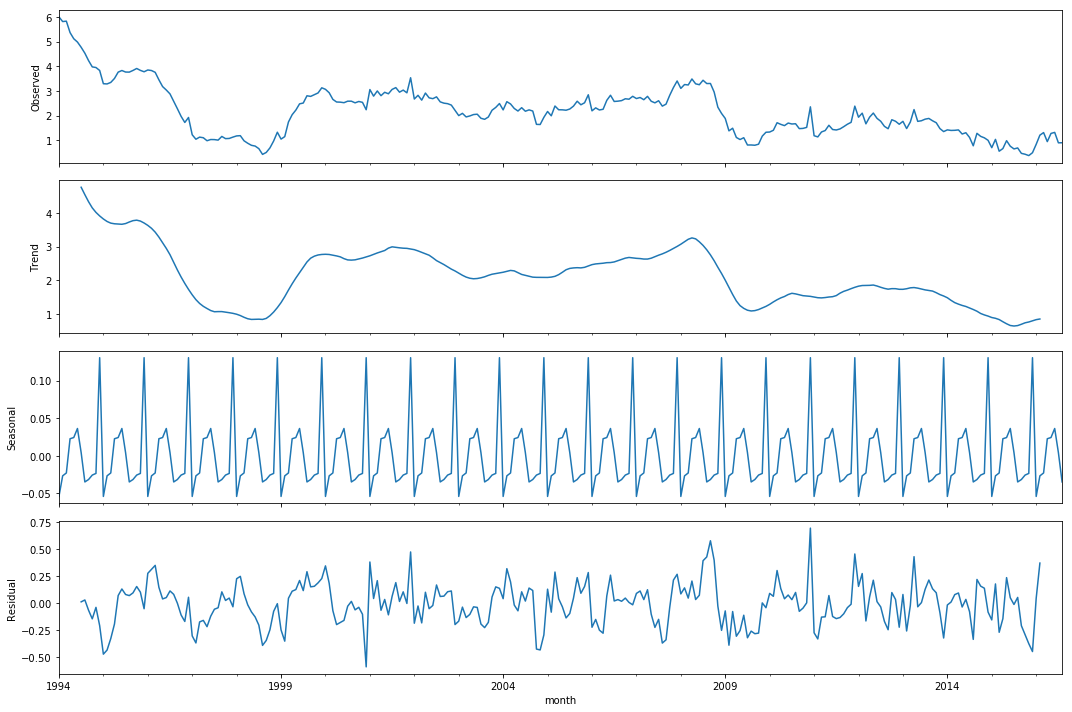

In [7]:
data['box_diff'] = data.box - data.box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_diff[12:])[1])

Критерий Дики-Фуллера **отвергает** гипотезу нестационарности, но ** избавиться от тренда не удалось**. Попробуем добавить еще обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


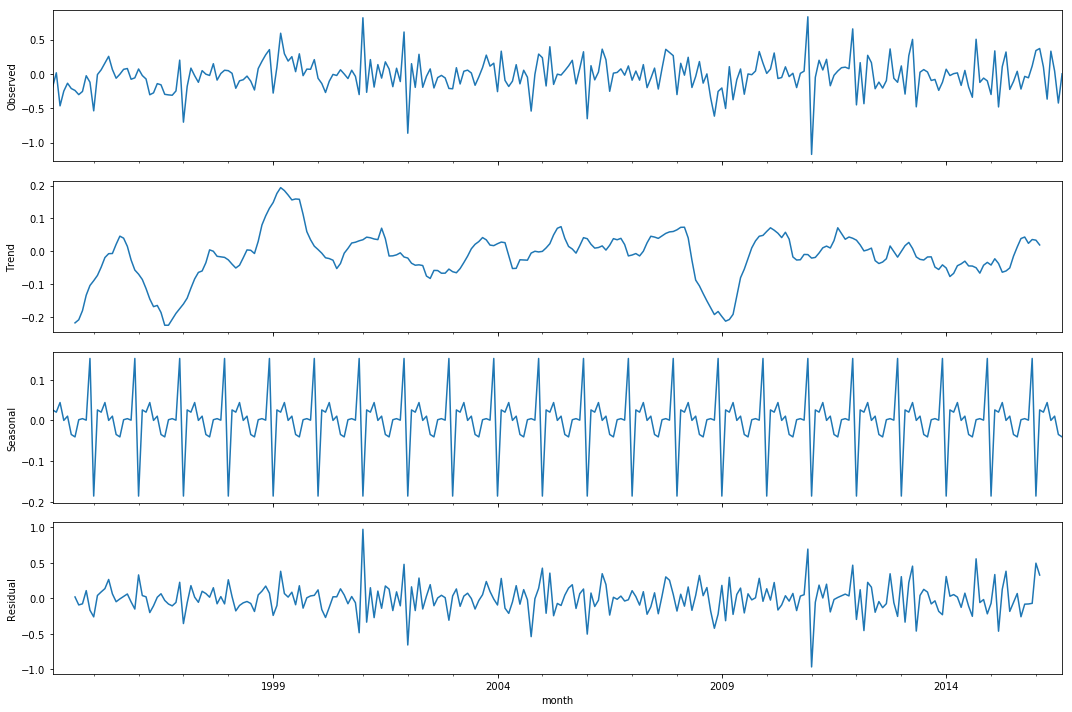

In [8]:
data['box_diff2'] = data.box_diff - data.box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше - тренда больше нет. 

### 4. Подбор модели, выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного р¤да:

In [1]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

NameError: name 'plt' is not defined

Начальные приближения: Q=0, q=1, P=1, p=5

In [24]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [25]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [26]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучаетс¤ и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
Wall time: 10.6 s


In [27]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
20  (5, 1, 1, 0) -5.260134
12  (3, 1, 1, 0) -4.995859
18  (5, 0, 1, 0) -4.545935
16  (4, 1, 1, 0) -3.975974
17  (5, 0, 0, 0) -2.104961


Лучшая модель:

In [28]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Mon, 08 May 2017   AIC                             -5.260
Time:                                    21:44:15   BIC                             23.932
Sample:                                01-01-1993   HQIC                             6.443
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

### 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.296151
Критерий Дики-Фуллера: p=0.000000


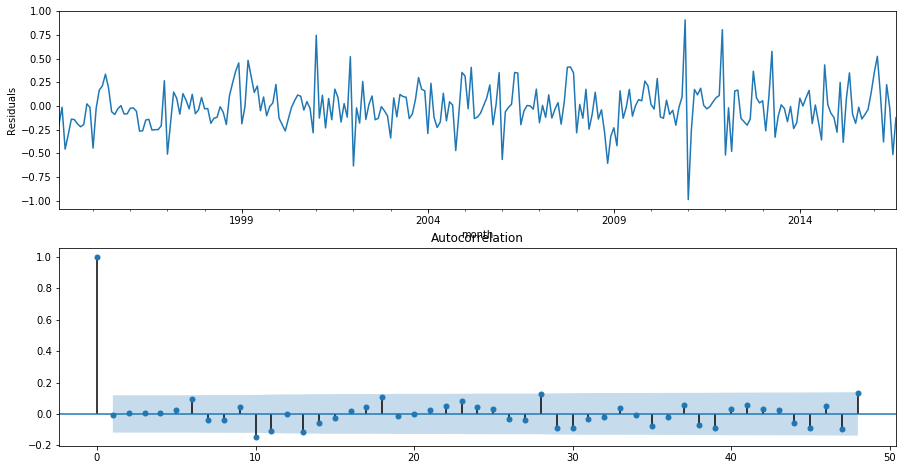

In [29]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждаетс¤ критерием Стьюдента) стационарны (подтверждаетс¤ критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждаетс¤ критерием Бьюнга-Кокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

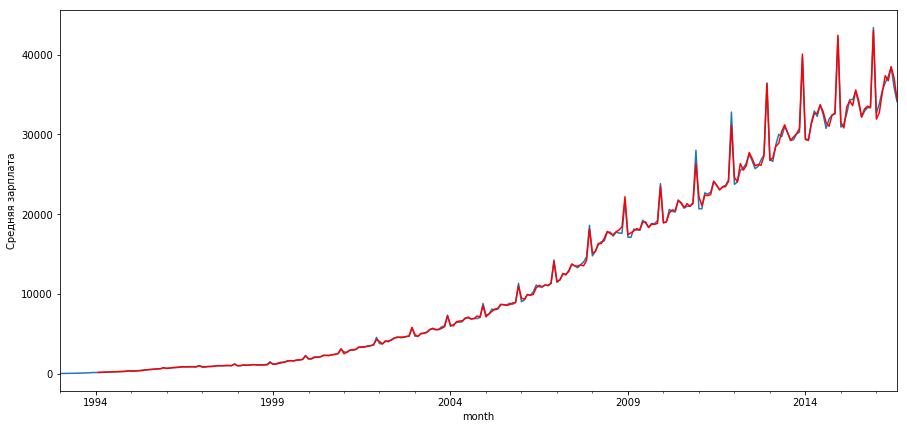

In [39]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Средняя зарплата')
pylab.show()

### 7. Прогнозирование с помощью финальной модели.

In [32]:
data

,WAG_C_M,box,box_diff,box_diff2,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,NaN,30.600000
1993-06-01,47.4,6.690719,NaN,NaN,37.500000
1993-07-01,56.0,7.161310,NaN,NaN,47.400000
1993-08-01,65.4,7.618224,NaN,NaN,56.000000
1993-09-01,80.9,8.275619,NaN,NaN,65.400000


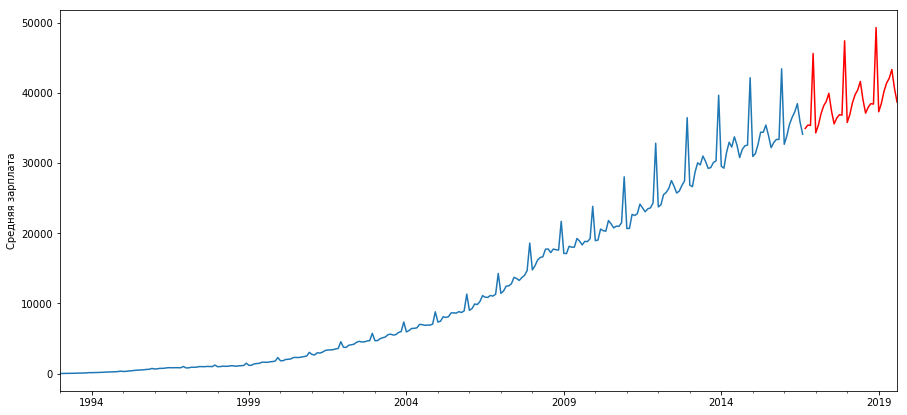

In [50]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Средняя зарплата')
pylab.show()